# Systrace Parser

In [1]:
import logging
from conf import LisaLogging
LisaLogging.setup()

2020-02-05 04:36:06,175 INFO    : root         : Using LISA logging configuration:
2020-02-05 04:36:06,178 INFO    : root         :   /home/ubuntu/Android/lisa_old/logging.conf


In [2]:
%pylab inline

import os
from time import sleep

# Support to access the remote target
import devlib
from env import TestEnv

# Import support for Android devices
from android import Screen, Workload

from devlib.utils.android import adb_command

# Support for trace events analysis
from trace import Trace

# Suport for FTrace events parsing and visualization
import trappy
import glob

import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame

import ipywidgets as widgets
from IPython.display import display

from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import Javascript, display

from android import System

import subprocess

from systrace_parser import systrace_parser

2019-11-23 06:04:27,804 INFO    : root         : Generating grammar tables from /usr/lib/python2.7/lib2to3/Grammar.txt
2019-11-23 06:04:27,818 INFO    : root         : Generating grammar tables from /usr/lib/python2.7/lib2to3/PatternGrammar.txt


Populating the interactive namespace from numpy and matplotlib


## Test environment setup

**devlib** requires the ANDROID_HOME environment variable configured to point to your local installation of the Android SDK. If you have not this variable configured in the shell used to start the notebook server, you need to run a cell to define where your Android SDK is installed or specify the ANDROID_HOME in your target configuration.

In case more than one Android device are conencted to the host, you must specify the ID of the device you want to target in **my_target_conf**. Run **adb devices** on your host to get the ID.

In [3]:
import os
os.environ['ANDROID_HOME'] = '/home/ubuntu/Android/AndroidSDK/'

In [4]:
conf = {
    
    # Target platform and board
    "platform"    : 'android',
    "board"       : 'pixel',

    # Device ID
    #"device"      : "HT6670300102",
    
    # Android home
    "ANDROID_HOME" : "/home/ubuntu/Android/AndroidSDK",
    
    # Lisa home
    "LISA_HOME" : "/home/ubuntu/Android/lisa_old",

    # Systrace home
    "SYSTRACE_HOME" : "/ipynb/performance/testingdata",
    
    "MAX_CORE_NUM" : 8
}

## Filters

In [6]:
trace_mark_filters = {
    'launching' : {
        'SMARK' : {'context' : 'launching:', 'type' : 'S'}, 
        'EMARK' : {'context' : 'launching:', 'type' : 'F'},
    },
    'ActivityThreadMain' : {
        'SMARK' : {'context' : 'ActivityThreadMain', 'type' : 'B'}, 
        'EMARK' : {'context' : 'ActivityThreadMain', 'type' : 'E'},
    },
    'bindApplication' : {
        'SMARK' : {'context' : 'bindApplication', 'type' : 'B'}, 
        'EMARK' : {'context' : 'bindApplication', 'type' : 'E'},
    },
    'activityStart' : {
        'SMARK' : {'context' : 'activityStart', 'type' : 'B'}, 
        'EMARK' : {'context' : 'activityStart', 'type' : 'E'},
    },
    'activityResume' : {
        'SMARK' : {'context' : 'activityResume', 'type' : 'B'}, 
        'EMARK' : {'context' : 'activityResume', 'type' : 'E'},
    },
    'Choreographer' : {
        'SMARK' : {'context' : 'Choreographer#doFrame', 'type' : 'B'}, 
        'EMARK' : {'context' : 'Choreographer#doFrame', 'type' : 'E'},
        'SEPERATE' : [0, 1],
    },
    'setSurface' : {
        'SMARK' : {'context' : 'setSurface', 'type' : 'B'}, 
        'EMARK' : {'context' : 'setSurface', 'type' : 'E'},
    },
}

In [7]:
def MismatchedStringWithoutNumber(comp1, comp2):
    comp1 = unicode(comp1)
    comp2 = unicode(comp2)
    count = 0
    for index in range(min(len(comp1), len(comp2))):
        if comp1[index] != comp2[index] and not comp1[index].isnumeric() and not comp1[index].isnumeric():
            count += 1
            
    return count
#print(MismatchedStringWithoutNumber('A207FSH9_POS_190822_190822_104817_calllog?', 'A207FSH9_POS_190822_180922_104475_calllog1'))

## Select systraces

In [8]:

count = 0
dirname = ''
dirnames = ''
chboxes = list()
chboxes_descriptions = list()

for (path, dir, files) in os.walk(conf['LISA_HOME'] + conf['SYSTRACE_HOME'] + '/'):
    if len(dir) > 0:
        dirnames = dir
    file_groups = list()
    for filename in files:
        if filename.split('.')[-1] == 'html':
            filename = filename[:-5]
            #print(filename)
            new_one = True
            for file_group in file_groups:
                #length_of_file = len(filename)
                #if length_of_file == len(file_group) and filename[:length_of_file/2] == file_group[:length_of_file/2]:
                if not MismatchedStringWithoutNumber(filename, file_group):
                    #print('before  {}'.format(file_groups))
                    #if not file_group.contains('[?]'):
                    #    file_groups.remove(file_group)
                        #file_groups.append('{}?{}'.format(file_group[:-6],file_group[-5:]))
                    #    file_groups.append('{}[?]'.format(file_group[:-3]))
                        #print('after  {}'.format(file_groups))
                    new_one = False
                    break
            if new_one:
                file_groups.append(filename)

    for file_group in file_groups:
        chboxes_descriptions.append('{}{}'.format(dirname, file_group))
    if len(dirnames) > count:
        dirname = dirnames[count] + '/'
    else:
        dirname = ''
    count += 1
    
chboxes_descriptions.sort()
#display(chboxes_descriptions)
for chboxes_description in chboxes_descriptions:
        chboxes.append(widgets.Checkbox(
                value=False,
                description=chboxes_description.decode("utf-8"),
                disabled=False,
                layout=widgets.Layout(width="200%"),
                style={'description_width': 'initial'}
        ))

toggle = widgets.ToggleButton(
    description='START'
)

#chboxes[4].value = True
#chboxes[16].value = True

display(widgets.VBox(chboxes))

VkJveChjaGlsZHJlbj0oQ2hlY2tib3godmFsdWU9RmFsc2UsIGRlc2NyaXB0aW9uPXUnQTAxNUYvQTAxNUZTSzVfUU9TXzE5MTEyMV8xOTExMjFfMTE1MzU4X2hlbGxvd29ybGQnLCBsYXlvdXTigKY=


## Run cells

Please select over two of systrace files and press the run button to execute below cells.
You could see the some graphs of group1 or gruop2 to compare.

In [40]:
def run_all(button):
    #get_ipython().run_cell()
    display(Javascript('IPython.notebook.execute_cells_below()'))

button = widgets.Button(description="Run all below")
button.on_click(run_all)
display(button)

<IPython.core.display.Javascript object>

Button(description=u'Run all below', style=ButtonStyle())

## Get file list

In [41]:
filelist = list()
title = list()

for chbox in chboxes:
    if chbox.value:
        #print(chbox.description)
        file_path = chbox.description.split('/')
        new_file_path = ''
        if len(file_path) > 1:
            for idx in range(len(file_path) - 1):
                new_file_path += file_path[idx] + '/'
        #length_of_file = len(file_path[-1])
        #new_file_path += file_path[-1][:-3] + '*.html'
        new_file_path += '*.html'
        #print(new_file_path)
        
        gathering_filelist = list()
        for dir_file in glob.glob(conf['LISA_HOME'] + conf['SYSTRACE_HOME'] + '/' + new_file_path):
            if not MismatchedStringWithoutNumber(file_path[-1], dir_file.split('/')[-1]):
                #print(dir_file)
                gathering_filelist.append(dir_file)
        filelist.append(gathering_filelist)
        #filelist[-1].sort()
        title += [file_path[-2] + "_" + file_path[-1]]

if len(filelist) == 0:
    raise  ValueError('Please select some groups of systrace in the over cell.')

Please select two groups of systrace to analysis.

## Read Files

In [42]:
group1 = systrace_parser(trace_mark_filters, filelist[0], title[0])
group2 = systrace_parser(trace_mark_filters, filelist[1], title[1])

In [14]:
group1.run()
group2.run()

Parsing GIGEUSG2_POS_190701_190701_144926_gallery.html - 153560 lines are Ok
Parsing GIGEUSG2_POS_190701_190701_154437_gallery.html - 155031 lines are Ok
Parsing GIGEUSG2_POS_190701_190701_135024_gallery.html - 144883 lines are Ok
Parsing GIGEUSH8_QOS_190829_190828_222304_gallery.html - 149632 lines are Ok
Parsing GIGEUSH8_QOS_190829_190828_211640_gallery.html - 149044 lines are Ok
Parsing GIGEUSH8_QOS_190829_190828_232929_gallery.html - 169323 lines are Ok


## Analysis

### The timing of marking data

The operation times of each trace_mark_filters tags of systrac.

In [15]:
list_of_df = group1.get_marking_time()
print(group1.title)
for df in list_of_df:
    display(df * 1000)

GIGEUSG2_Gallery_GIGEUSG2_POS_190701_190701_144926_gallery


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
1569.0,NaN,1.805,0.014,NaN,NaN,NaN,NaN,NaN
9634.0,0.003,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1243.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,212.52
1796.0,0.009,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8359.0,NaN,6.322,NaN,NaN,NaN,NaN,NaN,NaN
9929.0,NaN,NaN,NaN,41.613,NaN,5.931,NaN,NaN
1570.0,NaN,0.585,0.630,NaN,NaN,NaN,NaN,NaN
3633.0,1.892,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2386.0,0.162,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
1793.0,0.006,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1570.0,NaN,1.101,0.027,NaN,NaN,NaN,NaN,NaN
1851.0,NaN,0.096,0.064,NaN,NaN,NaN,NaN,NaN
8454.0,0.580,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3142.0,NaN,0.263,7.580,NaN,NaN,NaN,NaN,NaN
2305.0,0.127,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9913.0,NaN,NaN,NaN,174.491,NaN,6.198,NaN,NaN
9895.0,NaN,NaN,NaN,37.059,NaN,6.053,NaN,NaN
1265.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,213.693


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
1568.0,NaN,0.624,1.012,NaN,NaN,NaN,NaN,NaN
1803.0,0.005,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8420.0,0.443,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9542.0,0.004,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9809.0,NaN,NaN,NaN,51.145,NaN,5.998,NaN,NaN
1256.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,216.495
3627.0,0.906,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3119.0,NaN,2.623,0.620,NaN,NaN,NaN,NaN,NaN
9800.0,11.084,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
list_of_df = group2.get_marking_time()
print(group2.title)
for df in list_of_df:
    display(df * 1000)

GIGEUSH8_Gallery_GIGEUSH8_QOS_190829_190828_222304_gallery


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
12632.0,NaN,NaN,NaN,38.438,NaN,5.818,NaN,NaN
1541.0,NaN,11.574,6.131,NaN,NaN,NaN,NaN,NaN
2566.0,NaN,1.374,0.054,NaN,NaN,NaN,NaN,NaN
12721.0,NaN,NaN,NaN,191.490,NaN,13.269,NaN,NaN
4553.0,NaN,4.721,NaN,NaN,NaN,NaN,NaN,NaN
2058.0,NaN,0.063,0.057,NaN,NaN,NaN,NaN,NaN
2765.0,0.163,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10798.0,NaN,6.558,NaN,NaN,NaN,NaN,NaN,NaN
4751.0,0.004,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
12682.0,NaN,NaN,NaN,225.731,NaN,11.164,NaN,NaN
10788.0,NaN,8.398,NaN,NaN,NaN,NaN,NaN,NaN
5734.0,NaN,42.898,31.092,NaN,73.525,NaN,10.79,NaN
12593.0,NaN,NaN,NaN,38.013,NaN,5.566,NaN,NaN
3645.0,2.878,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12615.0,NaN,NaN,NaN,133.135,NaN,6.832,NaN,NaN
12562.0,25.117,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12175.0,0.020,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10960.0,1.035,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
12160.0,0.028,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4547.0,NaN,5.658,NaN,NaN,NaN,NaN,NaN,NaN
5636.0,NaN,31.771,25.731,NaN,79.096,NaN,27.436,NaN
1541.0,NaN,0.995,0.006,NaN,NaN,NaN,NaN,NaN
1542.0,NaN,1.799,0.866,NaN,NaN,NaN,NaN,NaN
2572.0,NaN,1.305,0.044,NaN,NaN,NaN,NaN,NaN
2061.0,NaN,0.062,0.057,NaN,NaN,NaN,NaN,NaN
2670.0,0.184,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12625.0,NaN,NaN,NaN,135.832,NaN,25.442,NaN,NaN


### Launching Time(AVERAGE)

This section is showing the app launching time.

In [17]:
list_of_df = group1.get_marking_time()
count1 = 0

for df in list_of_df:
    get_launching = df[df['launching'] > 0]

    if len(get_launching.index) :
        count1 += 1
        try :
            sum_df1 = pd.concat([sum_df1, get_launching])
        except :
            sum_df1 = get_launching

try :
    sum_df1 = DataFrame(sum_df1.sum(axis=0)).swapaxes("index", "columns") 
    sum_df1.index = [group1.title]
    sum_df1 = sum_df1.replace(0, NaN).dropna(axis=1)
except:
    print("No launching time")

list_of_df = group2.get_marking_time()
count2 = 0

for df in list_of_df:
    get_launching = df[df['launching'] > 0]
    
    if len(get_launching.index) :
        count2 += 1
        try :
            sum_df2 = pd.concat([sum_df2, get_launching])
        except :
            sum_df2 = get_launching

try :
    sum_df2 = DataFrame(sum_df2.sum()).swapaxes("index", "columns") 
    sum_df2.index = [group2.title]
    sum_df2 = sum_df2.replace(0, NaN).dropna(axis=1)

    pd.concat([sum_df1 * 1000 / count1, sum_df2 * 1000 / count2])
except:
    print("No launching time")

### Process Time(AVERAGE)

Process time is from start to end timing within systrace tag of binadApplication / activityStart / ActivityThreadMain / ActivityResume.
 - time : total sum of time of running / runnable / sleeping / uninterruptible sleep.
 - running / runnable / sleeping / uninterruptible sleep : Process stat of cores.
 - setSurface : Just test and check the length of setSurface's tags.
 - launching : Sum of each tags, bindApplication, activityStart, ActivityThreadMain, activityResume, and Choreographer.

In [18]:
df1 = group1.get(systrace_parser.process_state()) * 1000
df1 = df1.fillna(0)
df1 = df1.round(3)
df1.columns.name = group1.title
#display(df1)

df2 = group2.get(systrace_parser.process_state()) * 1000
df2 = df2.fillna(0)
df2 = df2.round(3)
df2.columns.name = group2.title
#display(df2)

df_gap = df1 - df2
df_gap.columns.name = 'DIFF'
#display(df_gap)

display(pd.concat([df1, df2, df_gap], keys=[group1.title, group2.title, 'DIFF'], sort=False))
display(pd.concat([df1[:1], df2[:1], df_gap[:1]], keys=[group1.title, group2.title, 'DIFF'], sort=False))

setSurface  \
GIGEUSG2_Gallery_GIGEUSG2_POS_190701_190701_144... time                                0   
                                                   RUNNING                             0   
                                                   RUNNABLE                            0   
                                                   SLEEPING                            0   
                                                   UNINTERUPTIBLE_SLEEP                0   
                                                   UNINTERUPTIBLE_SLEEP(I/O)           0   
GIGEUSH8_Gallery_GIGEUSH8_QOS_190829_190828_222... time                                0   
                                                   RUNNING                             0   
                                                   RUNNABLE                            0   
                                                   SLEEPING                            0   
                                                   UNINTERUPTIBLE_SLEEP                0   
                                                   UNINTERUPTIBLE_SLEEP(I/O)           0   
DIFF                                               time                                0   
                                                   RUNNING                             0   
                                                   RUNNABLE                            0   
                                                   SLEEPING                            0   
                                                   UNINTERUPTIBLE_SLEEP                0   
                                                   UNINTERUPTIBLE_SLEEP(I/O)           0   

                                                                              Choreographer #0  \
GIGEUSG2_Gallery_GIGEUSG2_POS_190701_190701_144... time                                 13.559   
                                                   RUNNING                               2.225   
                                                   RUNNABLE                              0.053   
                                                   SLEEPING                             11.281   
                                                   UNINTERUPTIBLE_SLEEP                  0.000   
                                                   UNINTERUPTIBLE_SLEEP(I/O)             0.000   
GIGEUSH8_Gallery_GIGEUSH8_QOS_190829_190828_222... time                                 37.150   
                                                   RUNNING                               3.570   
                                                   RUNNABLE                              1.986   
                                                   SLEEPING                             31.076   
                                                   UNINTERUPTIBLE_SLEEP                  0.518   
                                                   UNINTERUPTIBLE_SLEEP(I/O)             0.000   
DIFF                                               time                                -23.591   
                                                   RUNNING                              -1.345   
                                                   RUNNABLE                             -1.933   
                                                   SLEEPING                            -19.795   
                                                   UNINTERUPTIBLE_SLEEP                 -0.518   
                                                   UNINTERUPTIBLE_SLEEP(I/O)             0.000   

                                                                              Choreographer #1  \
GIGEUSG2_Gallery_GIGEUSG2_POS_190701_190701_144... time                                 22.618   
                                                   RUNNING                               9.924   
                                                   RUNNABLE                              0.289   
                                                   SLEEPING               

,,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
GIGEUSG2_Gallery_GIGEUSG2_POS_190701_190701_144926_gallery,time,0,13.559,22.618,42.143,55.229,16.206,19.361,0
GIGEUSH8_Gallery_GIGEUSH8_QOS_190829_190828_222304_gallery,time,0,37.150,27.283,0.000,78.375,0.000,23.304,0
DIFF,time,0,-23.591,-4.665,42.143,-23.146,16.206,-3.943,0


### Processing time of setSurface

In [18]:
def ProcessingTime(group, index):
    result = dict()
    list_of_df = group.get_marking_time()
    sum = 0
    count = 0
    for df in list_of_df:
        df = df['setSurface'].fillna(0)
        max_value = df.max() * 1000
        sum += max_value
        count += 1
        result[count] = [max_value]
    #print("SUM : {}, AVG : {}".format(sum, sum/count))
    result['avg'] = [sum/count]
    
    df = DataFrame.from_dict(result)
    df.index = [group.title]
    return df

In [20]:
df1 = ProcessingTime(group1, 'setSurface')
df2 = ProcessingTime(group2, 'setSurface')
display(pd.concat([df1, df2]))

,1,2,3,avg
GIGEUSG2_Gallery_GIGEUSG2_POS_190701_190701_144926_gallery,16.633,15.251,11.084,14.322667
GIGEUSH8_Gallery_GIGEUSH8_QOS_190829_190828_222304_gallery,19.422,25.117,16.386,20.308333


### Uninterruptible Sleep

The count of uninterruptible sleep within each tags.

In [50]:
index1 = group1.unint_sleep()
index2 = group2.unint_sleep()
union_index = index1
for index in index2:
    if not index in union_index:
        union_index += [index]

union_index.sort()
        
df1 = group1.get(union_index, func='avg').sort_index()
df1 = df1.dropna(axis=1)

df2 = group2.get(union_index, func='avg').sort_index()
df2 = df2.dropna(axis=1)

,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume
uninter_reason//SyS_mprotect+0x8c/0x2a0,0.0,0.000000,0.666667,0.666667,0.000000,0.666667
uninter_reason//SyS_munmap+0x4c/0xb0,0.0,0.000000,0.000000,1.000000,0.000000,0.000000
uninter_reason//SyS_prctl+0x654/0xd18,0.0,0.000000,0.333333,1.333333,0.000000,1.333333
uninter_reason//__fdget_pos+0x44/0x60,0.0,0.000000,0.333333,0.000000,0.000000,0.000000
uninter_reason//__percpu_down_read+0x120/0x148,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
uninter_reason//do_page_fault+0x248/0x3f0,0.0,0.666667,4.666667,14.000000,1.333333,2.000000
uninter_reason//vm_mmap_pgoff+0x78/0x110,0.0,0.000000,1.000000,5.333333,0.000000,0.666667


,Choreographer #0,Choreographer #1,activityStart,activityResume
uninter_reason//SyS_mprotect+0x8c/0x2a0,1.000000,0.0,0.000000,0.000000
uninter_reason//SyS_munmap+0x4c/0xb0,0.333333,0.0,0.333333,0.000000
uninter_reason//SyS_prctl+0x654/0xd18,0.000000,0.0,0.000000,0.000000
uninter_reason//__fdget_pos+0x44/0x60,0.000000,0.0,0.000000,0.666667
uninter_reason//__percpu_down_read+0x120/0x148,0.000000,0.0,0.333333,0.000000
uninter_reason//do_page_fault+0x248/0x3f0,1.333333,0.0,2.000000,0.000000
uninter_reason//vm_mmap_pgoff+0x78/0x110,0.000000,0.0,0.333333,0.000000


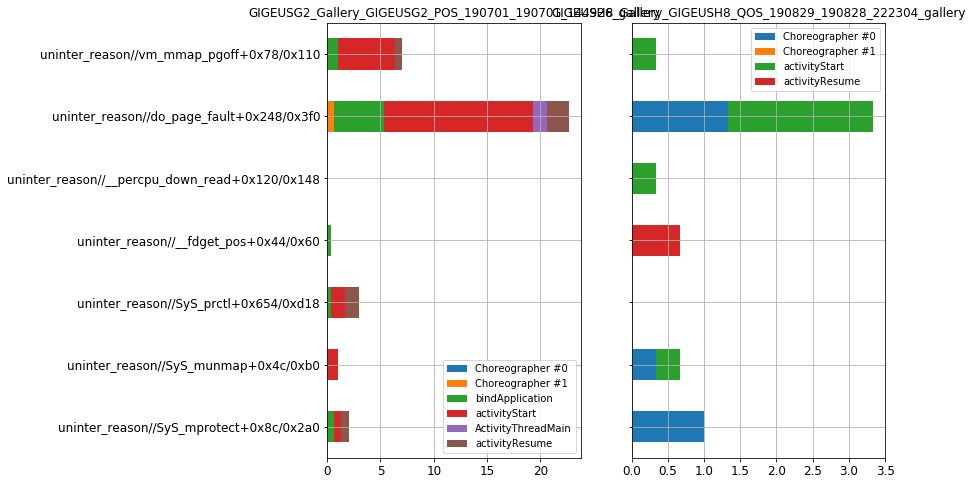

In [22]:
fig,axes = plt.subplots(nrows=1, ncols=2, sharey=True)

display(df1)
display(df2)
df1.plot(kind='barh', ax=axes[0], figsize=(10,8), grid=True, fontsize=12, stacked=True, title=group1.title)
df2.plot(kind='barh', ax=axes[1], figsize=(10,8), grid=True, fontsize=12, stacked=True, title=group2.title)

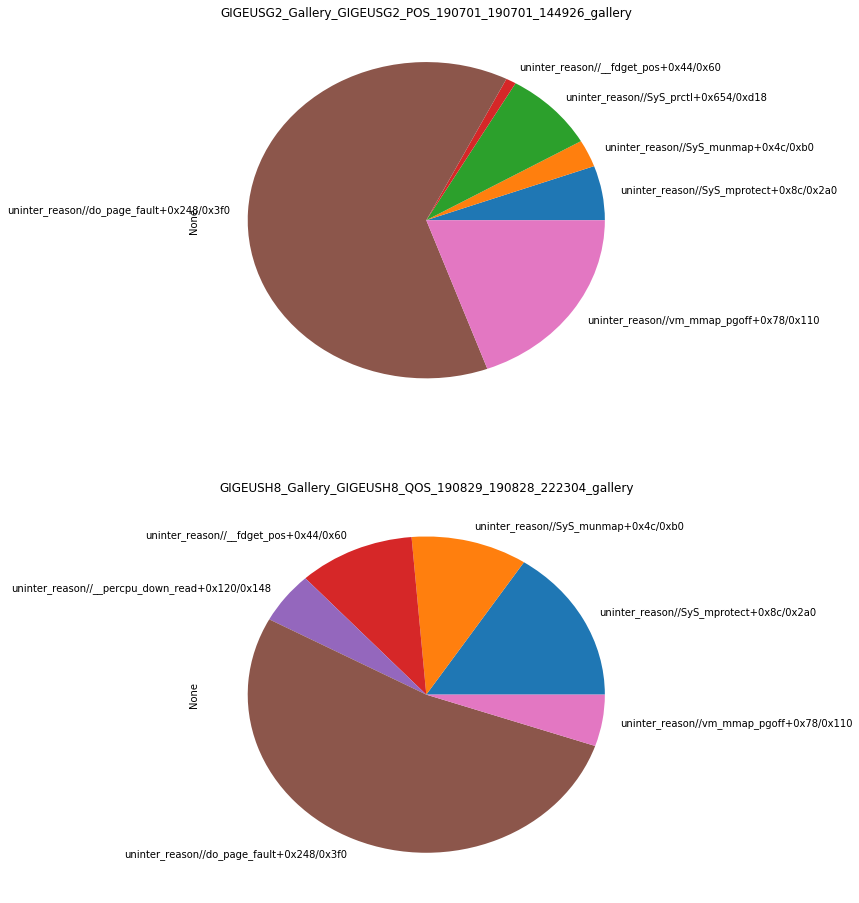

In [23]:
fig,axes = plt.subplots(nrows=2, ncols=1, sharey=True)
df1.sum(axis=1).plot(kind='pie', ax=axes[0], figsize=(8,16), title=group1.title)
df2.sum(axis=1).plot(kind='pie', ax=axes[1], figsize=(8,16), title=group2.title)

The number of count in each reason of uninterruptible sleep.

### Number of Running Cores(SUM)

The number of counting running cores when entering an app.

Choreographer #0  \
GIGEUSG2_Gallery_GIGEUSG2_POS_190701_190701_144... core0                 0   
                                                   core1                 0   
                                                   core2                 0   
                                                   core3                 0   
                                                   core4                 7   
                                                   core5                 6   
                                                   core6                 0   
                                                   core7                 4   
GIGEUSH8_Gallery_GIGEUSH8_QOS_190829_190828_222... core0                 1   
                                                   core1                 1   
                                                   core2                 1   
                                                   core3                 1   
                                                   core4                12   
                                                   core5                10   
                                                   core6                 5   
                                                   core7                 2   

                                                          Choreographer #1  \
GIGEUSG2_Gallery_GIGEUSG2_POS_190701_190701_144... core0                 0   
                                                   core1                 0   
                                                   core2                 0   
                                                   core3                 0   
                                                   core4                 7   
                                                   core5                 0   
                                                   core6                 7   
                                                   core7                 6   
GIGEUSH8_Gallery_GIGEUSH8_QOS_190829_190828_222... core0                 3   
                                                   core1                 1   
                                                   core2                 0   
                                                   core3                 1   
                                                   core4                 2   
                                                   core5                 0   
                                                   core6                14   
                                                   core7                 7   

                                                          bindApplication  \
GIGEUSG2_Gallery_GIGEUSG2_POS_190701_190701_144... core0              1.0   
                                                   core1             19.0   
                                                   core2              7.0   
                                                   core3              2.0   
                                                   core4             18.0   
                                                   core5             10.0   
                                                   core6             11.0   
                                                   core7             51.0   
GIGEUSH8_Gallery_GIGEUSH8_QOS_190829_190828_222... core0              NaN   
                                                   core1              NaN   
                                                   core2              NaN   
                                                   core3              NaN   
                                                   core4              NaN   
                                                   core5              NaN   
                                                   core6              NaN   
                                                   core7              NaN   

                                                          activityStart  \
GIGEUSG2_Gallery_GI

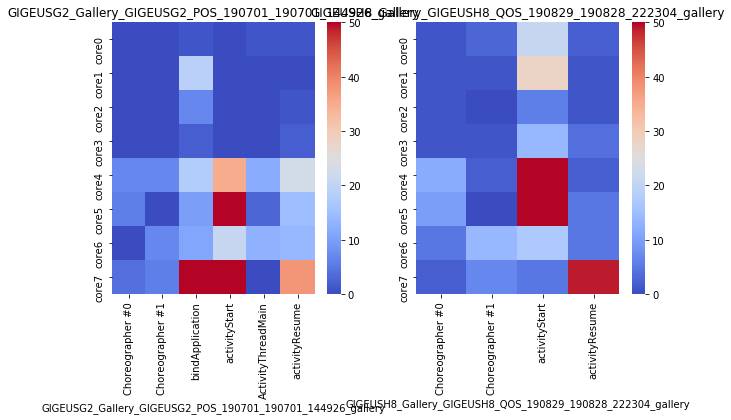

In [24]:
df1 = group1.get(group1.cores(), func='sum')
df1 = df1.dropna(axis=1)
df1.columns.name = group1.title
#display(df1)

df2 = group2.get(group2.cores(), func='sum')
df2 = df2.dropna(axis=1)
df2.columns.name = group2.title
#display(df2)
display(pd.concat([df1, df2], keys=[group1.title, group2.title], sort=False))

plt.figure(figsize=(10, 5))
#sb.palplot(sb.color_palette("hls", 8))
subplot(1,2,1, title=group1.title)
sb.heatmap(data=df1, cmap='coolwarm', center=25, vmax = 50);
subplot(1,2,2, title=group2.title)
sb.heatmap(data=df2, cmap='coolwarm', center=25, vmax = 50);

In [25]:
for parser in group1.parsers_of_testing:
    display(parser.get(group1.cores()))

,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,0,0,0,0,0,1,NaN
core1,NaN,0,0,4,0,0,0,NaN
core2,NaN,0,0,1,0,0,0,NaN
core3,NaN,0,0,0,0,0,1,NaN
core4,NaN,2,0,1,5,2,1,NaN
core5,NaN,3,0,0,14,0,0,NaN
core6,NaN,0,4,1,10,6,1,NaN
core7,NaN,1,0,36,70,0,23,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,0,0,0,0,0,0,NaN
core1,NaN,0,0,9,0,0,0,NaN
core2,NaN,0,0,3,0,0,1,NaN
core3,NaN,0,0,0,0,0,0,NaN
core4,NaN,5,1,7,20,8,2,NaN
core5,NaN,0,0,4,22,0,14,NaN
core6,NaN,0,2,9,8,3,12,NaN
core7,NaN,0,6,7,9,0,8,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,0,0,1,0,1,0,NaN
core1,NaN,0,0,6,0,0,0,NaN
core2,NaN,0,0,3,0,0,0,NaN
core3,NaN,0,0,2,0,0,1,NaN
core4,NaN,0,6,10,10,2,20,NaN
core5,NaN,3,0,6,33,3,1,NaN
core6,NaN,0,1,1,3,4,1,NaN
core7,NaN,3,0,8,16,0,7,NaN


In [26]:
for parser in group2.parsers_of_testing:
    display(parser.get(group2.cores()))

,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,0,2,NaN,2,NaN,2,NaN
core1,NaN,1,1,NaN,27,NaN,1,NaN
core2,NaN,0,0,NaN,0,NaN,1,NaN
core3,NaN,0,0,NaN,13,NaN,3,NaN
core4,NaN,5,2,NaN,14,NaN,0,NaN
core5,NaN,4,0,NaN,19,NaN,3,NaN
core6,NaN,2,0,NaN,6,NaN,1,NaN
core7,NaN,1,4,NaN,0,NaN,17,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,0,0,NaN,2,NaN,0,NaN
core1,NaN,0,0,NaN,0,NaN,0,NaN
core2,NaN,0,0,NaN,6,NaN,0,NaN
core3,NaN,0,0,NaN,1,NaN,0,NaN
core4,NaN,4,0,NaN,40,NaN,1,NaN
core5,NaN,3,0,NaN,6,NaN,1,NaN
core6,NaN,2,11,NaN,0,NaN,0,NaN
core7,NaN,1,0,NaN,0,NaN,18,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,1,1,NaN,17,NaN,0,NaN
core1,NaN,0,0,NaN,1,NaN,0,NaN
core2,NaN,1,0,NaN,0,NaN,0,NaN
core3,NaN,1,1,NaN,0,NaN,1,NaN
core4,NaN,3,0,NaN,13,NaN,1,NaN
core5,NaN,3,0,NaN,29,NaN,1,NaN
core6,NaN,1,3,NaN,11,NaN,4,NaN
core7,NaN,0,3,NaN,5,NaN,14,NaN


In [56]:
from systrace_parser import TAG_CORE_IDLE
def GetCoreStats(group):
    for parser in group.parsers_of_testing:
        rawdata = parser.get_rawdata('stat_core')
        index_key_list = list()
        df_list = list()
        
        for index_key in rawdata.keys():
            #print(index_key)
            index_key_list.append(index_key)

            core_state_dict = dict()
            for i in range(8):
                core_state_dict[i] = list()
            core_state_dict['selected'] = list()
            core_state_dict['time'] = list()

            for core_state in rawdata[index_key]:
                for i in range(8):
                    core_state_dict[i].append(core_state.get(i, TAG_CORE_IDLE))
                core_state_dict['selected'].append(core_state.get('selected', -1))
                core_state_dict['time'].append(core_state.get('time', -1))
            #display(DataFrame.from_dict(core_state_dict))
            df_list.append(DataFrame.from_dict(core_state_dict))

    return pd.concat(df_list, keys=index_key_list, sort=False).sort_values(by=['time'])
pd.set_option('display.max_rows', 500)

In [28]:
display(GetCoreStats(group1))

0  1  2  3  4  5  6  7  selected        time
ActivityThreadMain 0   I  I  I  I  R  I  V  I         6  439.258931
                   1   R  I  I  I  I  I  V  I         6  439.259485
                   2   R  I  I  I  R  I  V  I         6  439.259749
                   3   R  I  I  I  I  I  V  I         6  439.260987
                   4   I  I  I  I  I  V  R  I         5  439.261796
                   5   I  I  I  I  I  V  R  I         5  439.262183
                   6   I  I  R  R  I  V  I  I         5  439.262852
                   7   R  I  I  I  V  I  I  I         4  439.263429
                   8   V  I  I  R  I  I  I  I         0  439.265963
                   9   R  I  R  V  R  I  R  I         3  439.266839
bindApplication    0   I  V  I  I  R  I  I  I         1  439.272355
                   1   I  V  R  R  R  I  I  I         1  439.272977
                   2   I  V  I  I  R  I  I  I         1  439.273453
                   3   I  V  I  I  I  I  I  I         1  439.275211
                   4   I  V  I  I  I  I  I  I         1  439.275556
                   5   I  I  I  V  I  I  I  R         3  439.276200
                   6   I  R  R  V  I  R  R  I         3  439.276926
                   7   I  R  V  I  I  R  R  I         2  439.277091
                   8   I  I  V  I  I  I  I  R         2  439.288144
                   9   V  R  I  I  I  I  I  R         0  439.292807
                   10  R  R  V  I  I  R  I  I         2  439.293396
                   11  R  R  I  I  V  R  I  I         4  439.295490
                   12  R  R  I  I  V  R  I  I         4  439.296177
                   13  R  R  I  I  V  R  I  I         4  439.296534
                   14  I  I  I  I  V  R  I  R         4  439.297526
                   15  I  I  I  I  V  R  I  R         4  439.297583
                   16  I  I  R  I  V  R  I  I         4  439.299325
                   17  R  I  R  I  I  R  I  V         7  439.299753
                   18  I  R  I  I  I  R  I  V         7  439.300072
                   19  I  I  I  R  I  R  I  V         7  439.300415
                   20  R  I  R  I  I  I  V  I         6  439.313192
                   21  I  I  I  I  R  V  I  I         5  439.314915
                   22  R  I  I  I  I  R  I  V         7  439.321101
                   23  R  I  I  I  I  R  I  V         7  439.321135
                   24  R  I  I  I  I  R  I  V         7  439.321148
                   25  R  I  I  I  I  R  I  V         7  439.321191
                   26  R  I  I  I  I  R  I  V         7  439.321205
                   27  I  I  R  I  V  R  I  R         4  439.322556
                   28  I  R  I  I  V  R  I  R         4  439.322887
                   29  I  I  I  I  V  R  I  R         4  439.323119
                   30  I  I  R  I  I  V  I  R         5  439.327163
                   31  I  I  R  I  I  V  I  R         5  439.327490
                   32  I  I  I  I  I  V  I  I         5  439.327783
                   33  I  R  R  I  I  V  I  I         5  439.329069
                   34  I  R  R  I  I  V  I  I         5  439.329473
                   35  I  I  R  I  V  I  I  R         4  439.329743
                   36  I  I  R  I  V  I  I  R         4  439.330073
activityStart      0   I  I  I  I  I  V  I  I         5  439.330648
                   1   I  I  R  I  V  I  I  I         4  439.331299
                   2   I  I  I  I  V  I  I  I         4  439.331764
                   3   R  I  I  I  I  I  R  V         7  439.346595
                   4   R  I  I  R  I  R  R  V         7  439.350189
                   5   R  I  I  R  V  I  I  R         4  439.350881
                   6   I  I  R  I  V  I  I  I         4  439.351199
                   7   R  I  R  I  I  R  I  V         7  439.352062
                   8   R  I  R  I  I  R  V  R         6  439.355199
                   9   R  I  R  I  I  R  V  R         6  439.355410
                   10  I  I  R  I  I  I  I  V         7  439.356798
           

In [29]:
display(GetCoreStats(group2))

0  1  2  3  4  5  6  7  selected        time
activityStart    0   V  R  I  R  R  I  R  I         0  316.036854
                 1   V  R  R  R  R  I  I  I         0  316.037021
                 2   V  R  R  I  R  I  I  I         0  316.037113
                 3   V  R  I  R  R  I  I  I         0  316.037478
                 4   V  I  R  R  R  I  I  I         0  316.042195
                 5   V  I  I  I  I  I  I  I         0  316.043387
                 6   V  I  I  I  I  I  R  I         0  316.043951
                 7   V  I  I  I  I  R  I  I         0  316.044507
                 8   V  I  I  R  I  I  I  I         0  316.045783
                 9   V  I  I  R  R  R  R  I         0  316.051753
                 10  V  I  I  I  I  I  I  I         0  316.052981
                 11  V  I  R  I  I  I  R  I         0  316.053618
                 12  V  I  R  R  I  I  I  I         0  316.055747
                 13  V  R  I  I  I  I  R  I         0  316.056567
                 14  V  I  I  R  R  I  I  I         0  316.057722
                 15  V  I  I  I  I  I  I  I         0  316.059075
                 16  V  I  I  I  I  I  I  I         0  316.059449
                 17  I  I  I  I  I  V  I  I         5  316.061377
                 18  I  I  I  R  I  V  I  I         5  316.061906
                 19  I  I  I  I  I  V  I  I         5  316.064907
                 20  I  I  I  I  R  V  R  I         5  316.065589
                 21  I  I  I  I  R  V  I  I         5  316.066260
                 22  I  I  R  I  I  V  I  I         5  316.066839
                 23  I  R  I  R  I  V  I  I         5  316.067931
                 24  I  I  I  R  I  V  I  I         5  316.068722
                 25  I  R  I  I  I  V  I  I         5  316.069141
                 26  I  I  I  I  I  V  I  I         5  316.069277
                 27  R  I  I  I  I  V  I  I         5  316.069762
                 28  R  I  I  R  I  V  I  I         5  316.071009
                 29  I  I  I  R  I  V  I  I         5  316.071081
                 30  I  I  I  R  R  V  I  I         5  316.071877
                 31  I  I  I  R  I  V  I  I         5  316.072002
                 32  I  I  I  R  I  V  I  I         5  316.072726
                 33  I  I  I  R  I  V  R  I         5  316.072967
                 34  I  I  I  R  I  V  I  I         5  316.073062
                 35  I  R  I  I  I  V  I  I         5  316.074492
                 36  I  R  I  I  I  V  I  I         5  316.074579
                 37  I  R  I  I  I  V  I  I         5  316.074701
                 38  I  R  I  I  I  V  I  I         5  316.075100
                 39  R  R  R  I  I  V  I  I         5  316.079660
                 40  R  R  R  I  I  V  I  I         5  316.079825
                 41  I  R  I  I  I  V  I  I         5  316.080259
                 42  I  R  I  I  I  V  I  I         5  316.080296
                 43  I  R  I  I  I  V  I  I         5  316.080606
                 44  R  R  I  I  I  R  V  I         6  316.081122
                 45  I  I  I  R  I  I  V  R         6  316.082438
                 46  I  I  I  R  I  I  V  R         6  316.082714
                 47  I  I  I  I  I  R  I  V         7  316.086570
                 48  I  R  I  I  I  I  I  V         7  316.090619
                 49  I  R  R  I  I  I  I  V         7  316.091277
                 50  R  R  I  I  I  I  I  V         7  316.092056
                 51  I  R  I  I  I  I  I  V         7  316.092304
                 52  I  R  I  R  I  I  V  I         6  316.093418
                 53  I  R  R  I  I  I  V  I         6  316.093837
                 54  I  R  I  I  I  I  V  I         6  316.093986
                 55  I  R  I  I  I  I  V  I         6  316.094128
                 56  I  I  R  R  I  I  V  R         6  316.095580
                 57  I  R  R  R  I  I  V  R         6  316.098734
                 58  I  R  I  I  I  I  V  R         6  316.099574
                 59  I  R  I  I  R  I  V  I         6  316.09

### Cpu Frequency

The graph to show a min lock status of core frequency.

In [59]:
from systrace_parser import CPU_FREQUENCY_LIMITS
def DrawCorrectedData(group, tyep_filter, data_label, func):
    prevalue = dict()
    list_of_df_for_start = group.get_marking_time(dtype='start')
    list_of_df_for_end = group.get_marking_time(dtype='end')
    idx = 0

    for item in group.get(tyep_filter, func='array'):
        df = DataFrame(item, columns=['cpu_id', 'time', data_label])
        df = df.apply(pd.to_numeric)
        
        ### to darw launcging time ++
        min_freq = df[data_label].min()
        prevalue['launching'] = min_freq
        
        if len(list_of_df_for_start) > idx:
            launching_time = list_of_df_for_start[idx]['launching'].max()
            if launching_time > 0:
                df = df.append({'cpu_id' : 'launching', 
                           'time' : launching_time, 
                           data_label : ((min_freq + 1) * 2)}, ignore_index=True) 
        if len(list_of_df_for_end) > idx:
            launching_time = list_of_df_for_end[idx]['launching'].max()
            if launching_time > 0:
                df = df.append({'cpu_id' : 'launching', 
                           'time' : launching_time,
                           data_label : min_freq}, ignore_index=True)
        ### to darw launcging time --
        
        if func != 0:
            df = func(df)
            
        length = len(df.index)
            
        for i in range(length):
            #display(df.iloc[i])
            if df.iloc[i]['cpu_id'] in prevalue.keys():
                df = df.append({'cpu_id' : df.iloc[i]['cpu_id'], 
                           'time' : (df.iloc[i]['time'] - 0.000001), 
                           data_label : prevalue[df.iloc[i]['cpu_id']]}, ignore_index=True) 
                #display(df.iloc[i])
            prevalue[df.iloc[i]['cpu_id']] = df.iloc[i][data_label]
        
        idx += 1
        df.index = df['time']
        df = df.sort_index()
        df.groupby(['cpu_id'])[data_label].plot(legend=True, figsize=(15,4))
        plt.show()

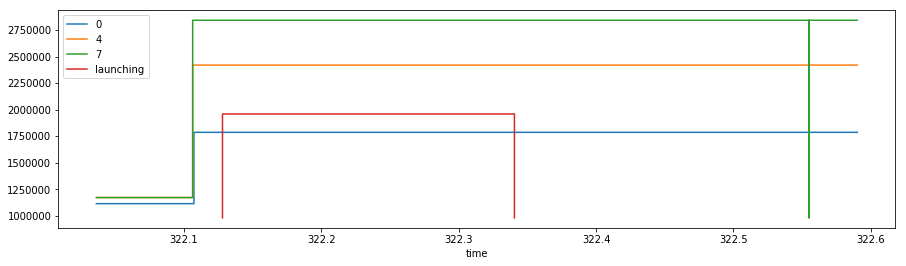

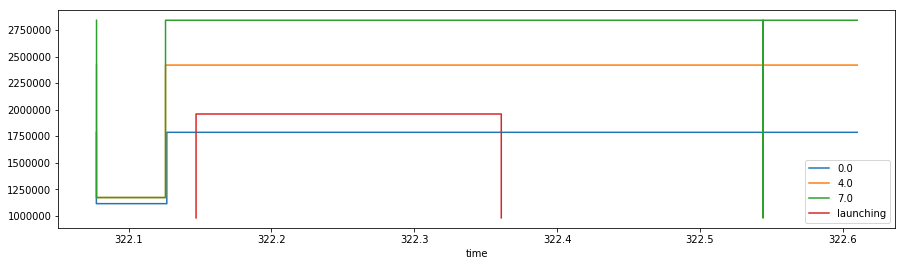

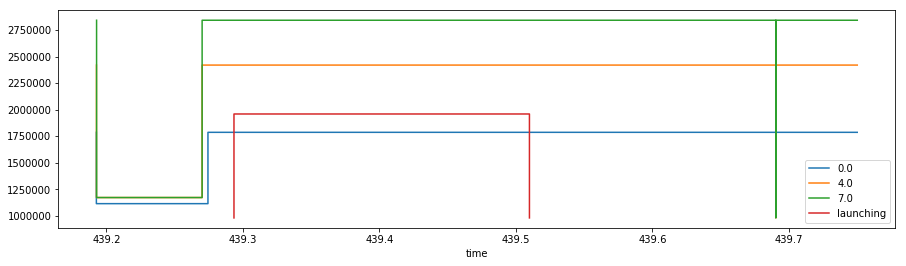

In [31]:
DrawCorrectedData(group1, CPU_FREQUENCY_LIMITS, 'min', 0)

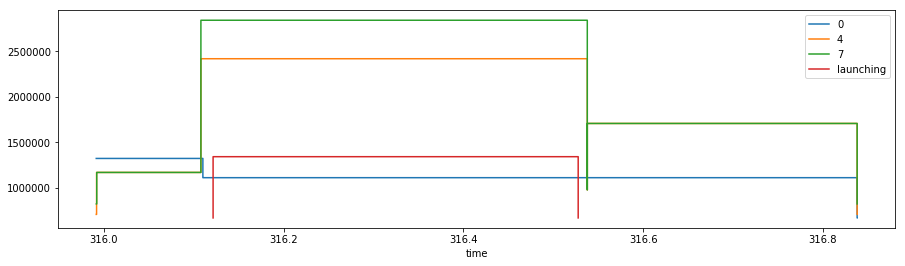

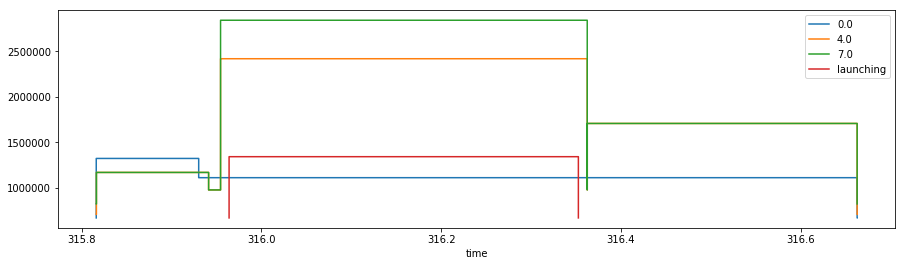

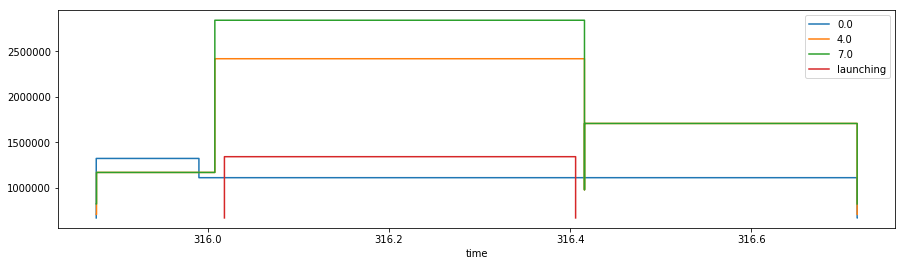

In [32]:
DrawCorrectedData(group2, CPU_FREQUENCY_LIMITS, 'min', 0)

### Cpu Idle

The graph to show a min lock status of core Idle.

In [62]:
from systrace_parser import CPU_IDLE
def PreprocessingForCPUIDLE(df):
    try :
        df_launching = df[df.cpu_id == 'launching']
    except :
        df = pd.concat([df[df.cpu_id == 0], df[df.cpu_id == 4], df[df.cpu_id == 7]])

        df.loc[df.state >= 4294967295, 'state'] = -1
        df['state'] = df['state'] + 1
        
        return df

    df = pd.concat([df[df.cpu_id == 0], df[df.cpu_id == 4], df[df.cpu_id == 7]])

    df.loc[df.state >= 4294967295, 'state'] = -1
    df['state'] = df['state'] + 1
    
    df = df[df.time >= (df_launching['time'].iloc[0] - 0.1)]
    df = df[df.time <= (df_launching['time'].iloc[1] + 0.1)]
    
    df = pd.concat([df, df_launching])
    return df

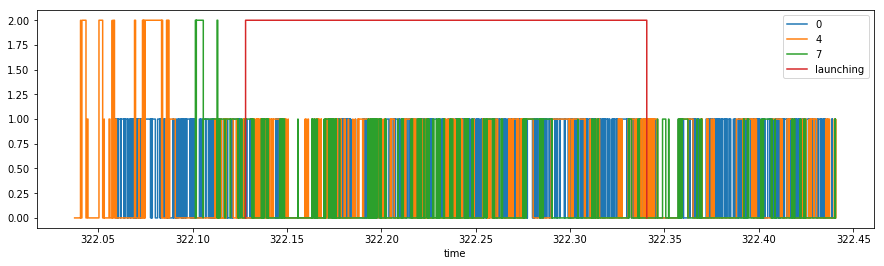

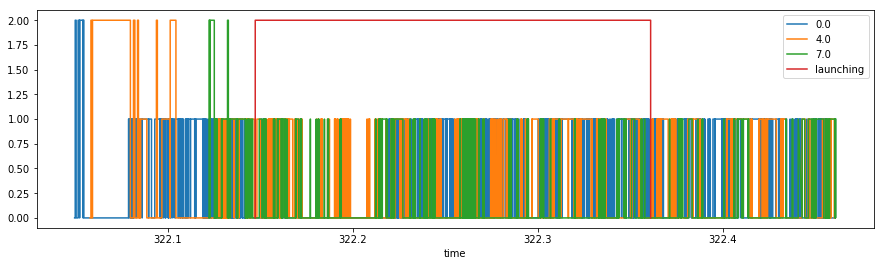

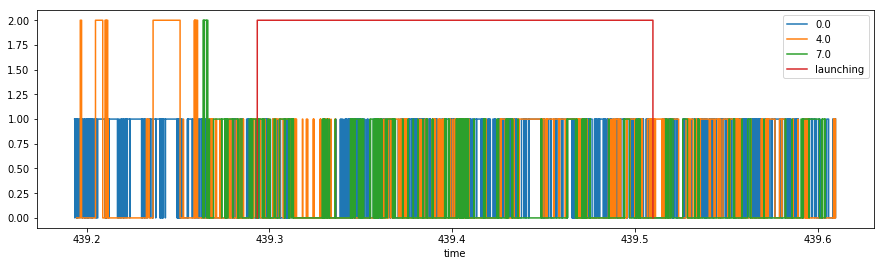

In [34]:
DrawCorrectedData(group1, CPU_IDLE, 'state', PreprocessingForCPUIDLE)

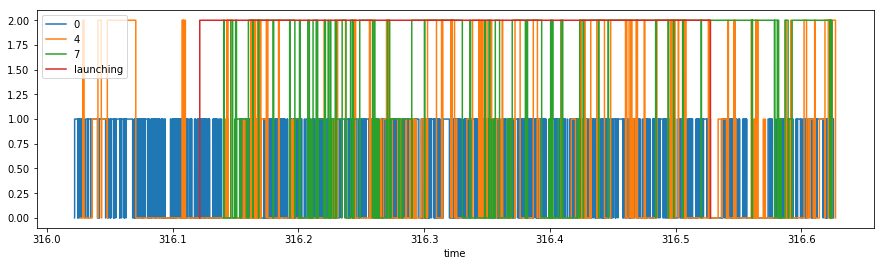

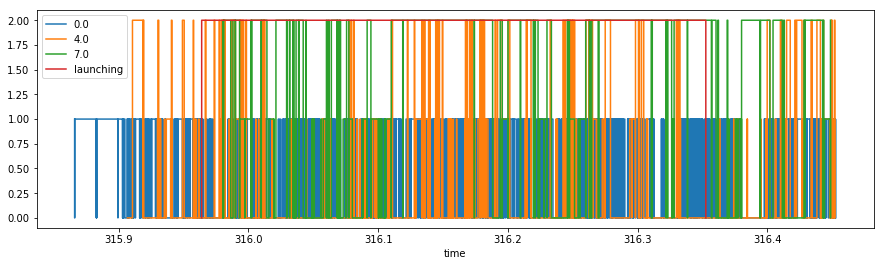

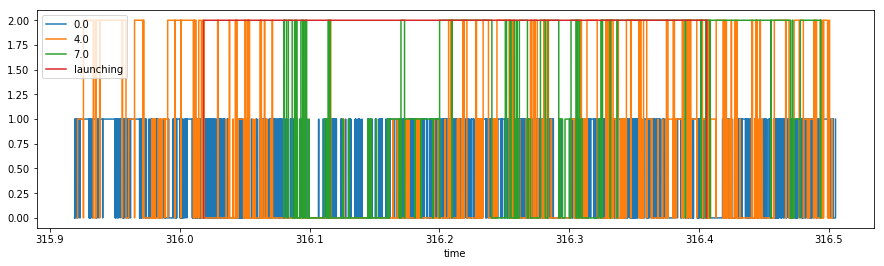

In [35]:
DrawCorrectedData(group2, CPU_IDLE, 'state', PreprocessingForCPUIDLE)

### Lock Contention

In [36]:
df1 = group1.get(['lock_contention']) * 1000
df1 = df1.fillna(0)
df1 = df1.round(3)
df1.columns.name = group1.title
#display(df1)

df2 = group2.get(['lock_contention']) * 1000
df2 = df2.fillna(0)
df2 = df2.round(3)
df2.columns.name = group2.title
#display(df2)

df_gap = df1 - df2
df_gap.columns.name = 'DIFF'
#display(df_gap)

display(pd.concat([df1, df2, df_gap], keys=[group1.title, group2.title, 'DIFF'], sort=False))
#display(pd.concat([df1[:1], df2[:1], df_gap[:1]], keys=[group1.title, group2.title, 'DIFF'], sort=False))

,,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
GIGEUSG2_Gallery_GIGEUSG2_POS_190701_190701_144926_gallery,lock_contention,0,6.868,0,7.572,17.242,10.496,4.848,0
GIGEUSH8_Gallery_GIGEUSH8_QOS_190829_190828_222304_gallery,lock_contention,0,11.066,0,0.000,13.695,0.000,2.449,0
DIFF,lock_contention,0,-4.198,0,7.572,3.547,10.496,2.399,0


In [66]:
def DrawLockContention(parser):
    for lock_contention in parser.storage_lock_contention:
        lock_contention['owner'] = lock_contention['context'].split('owner ')[1].split(' waiters')[0]
        lock_contention['blocking'] = lock_contention['context'].split('blocking from')[1]
    df = DataFrame.from_dict(parser.storage_lock_contention)
    df.loc[df['duration'] > 0, 'duration'] *= 1000

    return df
        #if value == 'NaN':
            
        #else:
        #    display(DataFrame(df[value].value_counts()))

Liminated the lock contentions by the main thread is sleepping in an app.
(The effection means that lock contentions seem to effect to the app entry because the process stat was sleep.)

In [38]:
#for parser in group.parsers_of_testing:
parser = group1.parsers_of_testing[0]
df = DrawLockContention(parser)
df1 = df[df['effection'] == 'O']
display(group1.title)
display(df1.sort_values(by=['duration'], ascending=False))

u'GIGEUSG2_Gallery_GIGEUSG2_POS_190701_190701_144926_gallery'

,blocking,context,duration,effection,owner,pid,time,type
105,float com.android.server.wm.WindowManagerServ...,monitor contention with owner android.anim (15...,10.728,O,android.anim (1569),3085,322.174674,B
107,void com.android.server.wm.WindowManagerServi...,monitor contention with owner android.anim (15...,10.498,O,android.anim (1569),1381,322.175002,B
40,int com.android.server.am.MultiWindowManagerS...,monitor contention with owner Binder:1243_12 (...,8.944,O,Binder:1243_12 (4986),1243,322.122614,B
94,void com.android.server.wm.WindowManagerServi...,monitor contention with owner Binder:1243_12 (...,4.160,O,Binder:1243_12 (4986),1381,322.160546,B
95,boolean com.android.server.wm.Session.getInTo...,monitor contention with owner Binder:1243_12 (...,4.152,O,Binder:1243_12 (4986),1569,322.160640,B
98,void com.android.server.am.TaskChangeNotifica...,monitor contention with owner Binder:1243_15 (...,3.779,O,Binder:1243_15 (7345),1366,322.165881,B
128,void com.android.server.wm.WindowManagerServi...,monitor contention with owner Binder:1243_16 (...,3.682,O,Binder:1243_16 (7404),1381,322.255679,B
109,void com.android.server.wm.StackWindowControl...,monitor contention with owner android.anim (15...,3.351,O,android.anim (1569),7345,322.182330,B
111,void com.android.server.wm.WindowManagerServi...,monitor contention with owner android.anim (15...,3.334,O,android.anim (1569),7404,322.183070,B
104,void com.android.server.wm.WindowManagerServi...,monitor contention with owner Binder:1243_F (3...,3.296,O,Binder:1243_F (3085),1381,322.170162,B


In [39]:
#for parser in group.parsers_of_testing:
parser = group2.parsers_of_testing[0]
df = DrawLockContention(parser)
df2 = df[df['effection'] == 'O']
display(group2.title)
display(df2.sort_values(by=['duration'], ascending=False))

u'GIGEUSH8_Gallery_GIGEUSH8_QOS_190829_190828_222304_gallery'

,blocking,context,duration,effection,owner,pid,time,type
102,void com.android.server.wm.WindowSurfacePlace...,monitor contention with owner Binder:1501_3 (1...,13.584,O,Binder:1501_3 (1905) at void com.android.serve...,1541,316.527962,B
5,android.app.ActivityManager$StackInfo com.and...,monitor contention with owner Binder:1501_7 (2...,13.192,O,Binder:1501_7 (2232) at void com.android.serve...,1537,316.133814,B
4,int com.android.server.wm.WindowManagerServic...,monitor contention with owner Binder:1501_7 (2...,8.671,O,Binder:1501_7 (2232) at void com.android.serve...,1541,316.133293,B
77,void android.content.res.AssetManager.applySt...,monitor contention with owner ThreadUtil (5819...,8.514,O,ThreadUtil (5819) at int android.content.res.A...,5776,316.230318,B
6,float com.android.server.wm.WindowManagerServ...,monitor contention with owner Binder:1501_7 (2...,6.364,O,Binder:1501_7 (2232) at void com.android.serve...,3489,316.141094,B
36,boolean com.android.server.wm.WindowProcessCo...,monitor contention with owner android.anim (15...,6.229,O,android.anim (1541) at void com.android.server...,1537,316.169542,B
78,void com.android.server.wm.TaskChangeNotifica...,monitor contention with owner Binder:1501_7 (2...,6.011,O,Binder:1501_7 (2232) at int com.android.server...,1537,316.241133,B
93,void com.android.server.wm.WindowManagerServi...,monitor contention with owner android.anim (15...,4.950,O,android.anim (1541) at void com.android.server...,1537,316.292659,B
85,void com.android.server.wm.WindowManagerServi...,monitor contention with owner Binder:1501_9 (2...,4.569,O,Binder:1501_9 (2249) at int com.android.server...,1537,316.257244,B
7,int com.android.server.wm.WindowManagerServic...,monitor contention with owner android.anim (15...,4.503,O,android.anim (1541) at int com.android.server....,2232,316.143052,B


Sum of the lock contention's duration. The durations could be duplicated.

In [40]:
display(group1.title)
display(df1['duration'].sum())

u'GIGEUSG2_Gallery_GIGEUSG2_POS_190701_190701_144926_gallery'

86.59500000010212

In [41]:
display(group2.title)
display(df2['duration'].sum())

u'GIGEUSH8_Gallery_GIGEUSH8_QOS_190829_190828_222304_gallery'

175.84600000003547

Liminated the lock contentions by owners.

In [42]:
parser = group1.parsers_of_testing[0]
df = DrawLockContention(parser)
df = df[df['effection'] == 'O']
display(group1.title)
display(DataFrame(df['owner'].value_counts()))

u'GIGEUSG2_Gallery_GIGEUSG2_POS_190701_190701_144926_gallery'

,owner
Binder:1243_12 (4986),14
android.anim (1569),13
Binder:1243_15 (7345),9
Binder:1243_16 (7404),9
android.ui (1367),6
Binder:1243_F (3085),4
Binder:1243_13 (5234),3
thumbThread1 (9905),2
thread-pool-2 (9916),2
Thread-52 (9885),2


In [43]:
parser = group2.parsers_of_testing[0]
df = DrawLockContention(parser)
df = df[df['effection'] == 'O']
display(group2.title)
display(DataFrame(df['owner'].value_counts()))

u'GIGEUSH8_Gallery_GIGEUSH8_QOS_190829_190828_222304_gallery'

,owner
android.anim (1541) at void com.android.server.wm.WindowAnimator.animate(long)(WindowAnimator.java:141),10
android.anim (1541) at void com.android.server.wm.InputMonitor$1.run()(InputMonitor.java:125),8
android.anim (1541) at void com.android.server.wm.WindowSurfacePlacer.lambda$new$0$WindowSurfacePlacer()(WindowSurfacePlacer.java:61),6
"Binder:1501_9 (2249) at void com.android.server.wm.WindowManagerService.removeWindow(com.android.server.wm.Session, android.view.IWindow)(WindowManagerService.java:1919)",6
"Binder:1501_7 (2232) at int com.android.server.wm.WindowManagerService.relayoutWindow(com.android.server.wm.Session, android.view.IWindow, int, android.view.WindowManager$LayoutParams, int, int, int, int, long, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.view.DisplayCutout$ParcelableWrapper, android.util.MergedConfiguration, android.view.SurfaceControl, android.view.InsetsState)(WindowManagerService.java:2176)",4
"Binder:1501_3 (1905) at void com.android.server.am.ActivityManagerService.serviceDoneExecuting(android.os.IBinder, int, int, int)(ActivityManagerService.java:15655)",3
Binder:1501_9 (2249) at java.util.List com.android.server.am.ActivityManagerService.getRunningAppProcesses()(ActivityManagerService.java:11103),3
"Binder:1501_7 (2232) at int com.android.server.wm.WindowManagerService.addWindow(com.android.server.wm.Session, android.view.IWindow, int, android.view.WindowManager$LayoutParams, int, int, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.view.DisplayCutout$ParcelableWrapper, android.view.InputChannel, android.view.InsetsState)(WindowManagerService.java:1345)",3
Binder:1501_7 (2232) at void com.android.server.wm.ActivityTaskManagerService.activityPaused(android.os.IBinder)(ActivityTaskManagerService.java:2252),3
"android.anim (1541) at int com.android.server.wm.WindowManagerService.relayoutWindow(com.android.server.wm.Session, android.view.IWindow, int, android.view.WindowManager$LayoutParams, int, int, int, int, long, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.view.DisplayCutout$ParcelableWrapper, android.util.MergedConfiguration, android.view.SurfaceControl, android.view.InsetsState)(WindowManagerService.java:2176)",3


Text(0,0.5,'weight')

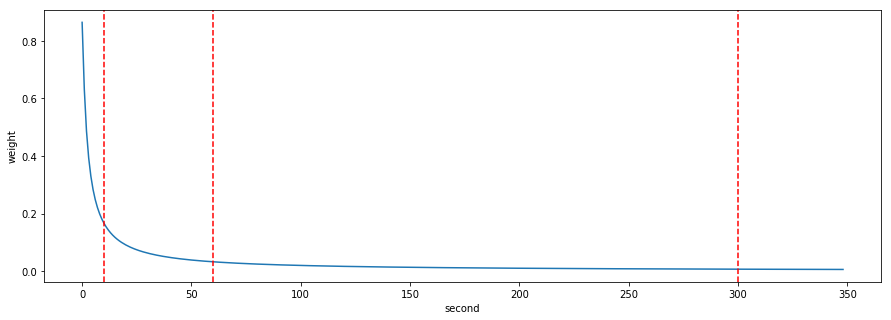

In [73]:
from math import exp


#display(np.exp(-2.0/np.arange(1,300.0)) * 2048)
plt.figure(figsize=(15,5))
plt.plot(1 - np.exp(-2.0/np.arange(1,350.0)))
plt.axvline(x=10, color='r', linestyle='--')
plt.axvline(x=60, color='r', linestyle='--')
plt.axvline(x=300, color='r', linestyle='--')
plt.xlabel('second')
plt.ylabel('weight')